In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [5]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:10<00:00, 18.93it/s]


In [6]:
print(len(lrv_test))

200


In [7]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [8]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [12]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [13]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)


xception   = Xception(include_top=False, input_shape=input_shape)(inputs)

83683744/83683744 [==============================] - 0s 0us/step


In [14]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                            

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Xception(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 1.2289 - accuracy: 0.5476

136/136 [==============================] - 127s 763ms/step - loss: 1.2289 - accuracy: 0.5476 - val_loss: 0.4880 - val_accuracy: 0.8582 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7870

136/136 [==============================] - 87s 632ms/step - loss: 0.5621 - accuracy: 0.7870 - val_loss: 0.1814 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.8476

136/136 [==============================] - 86s 629ms/step - loss: 0.4087 - accuracy: 0.8476 - val_loss: 0.1249 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8650

136/136 [==============================] - 86s 630ms/step - loss: 0.3519 - accuracy: 0.8650 - val_loss: 0.1372 - val_accuracy: 0.9515 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8808

136/136 [==============================] - 86s 630ms/step - loss: 0.3096 - accuracy: 0.8808 - val_loss: 0.0692 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8918

136/136 [==============================] - 88s 645ms/step - loss: 0.2748 - accuracy: 0.8918 - val_loss: 0.0601 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9055

136/136 [==============================] - 87s 636ms/step - loss: 0.2529 - accuracy: 0.9055 - val_loss: 0.0726 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9000

136/136 [==============================] - 87s 636ms/step - loss: 0.2483 - accuracy: 0.9000 - val_loss: 0.0599 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9050

136/136 [==============================] - 87s 632ms/step - loss: 0.2370 - accuracy: 0.9050 - val_loss: 0.0743 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9140

136/136 [==============================] - 85s 624ms/step - loss: 0.2160 - accuracy: 0.9140 - val_loss: 0.0524 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9140

136/136 [==============================] - 85s 623ms/step - loss: 0.2251 - accuracy: 0.9140 - val_loss: 0.0371 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9151

136/136 [==============================] - 86s 626ms/step - loss: 0.2073 - accuracy: 0.9151 - val_loss: 0.0495 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9174

136/136 [==============================] - 87s 630ms/step - loss: 0.2095 - accuracy: 0.9174 - val_loss: 0.0409 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9272

136/136 [==============================] - 88s 639ms/step - loss: 0.1829 - accuracy: 0.9272 - val_loss: 0.0522 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9288

136/136 [==============================] - 86s 628ms/step - loss: 0.1855 - accuracy: 0.9288 - val_loss: 0.0642 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9323

136/136 [==============================] - 86s 632ms/step - loss: 0.1694 - accuracy: 0.9323 - val_loss: 0.0353 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9254

136/136 [==============================] - 86s 630ms/step - loss: 0.1830 - accuracy: 0.9254 - val_loss: 0.0425 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9307

136/136 [==============================] - 87s 635ms/step - loss: 0.1728 - accuracy: 0.9307 - val_loss: 0.0393 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9304

136/136 [==============================] - 86s 632ms/step - loss: 0.1758 - accuracy: 0.9304 - val_loss: 0.0354 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9330

136/136 [==============================] - 85s 623ms/step - loss: 0.1633 - accuracy: 0.9330 - val_loss: 0.0529 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9373

136/136 [==============================] - 87s 633ms/step - loss: 0.1618 - accuracy: 0.9373 - val_loss: 0.0248 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9334

136/136 [==============================] - 88s 641ms/step - loss: 0.1614 - accuracy: 0.9334 - val_loss: 0.0379 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9348

136/136 [==============================] - 88s 645ms/step - loss: 0.1613 - accuracy: 0.9348 - val_loss: 0.0385 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9355

136/136 [==============================] - 87s 636ms/step - loss: 0.1628 - accuracy: 0.9355 - val_loss: 0.0288 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9410

136/136 [==============================] - 87s 634ms/step - loss: 0.1516 - accuracy: 0.9410 - val_loss: 0.0511 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9435

136/136 [==============================] - 89s 647ms/step - loss: 0.1426 - accuracy: 0.9435 - val_loss: 0.0557 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9451

136/136 [==============================] - 87s 634ms/step - loss: 0.1419 - accuracy: 0.9451 - val_loss: 0.0545 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9446

136/136 [==============================] - 86s 632ms/step - loss: 0.1430 - accuracy: 0.9446 - val_loss: 0.0378 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9414

136/136 [==============================] - 87s 633ms/step - loss: 0.1490 - accuracy: 0.9414 - val_loss: 0.0372 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9453

136/136 [==============================] - 87s 633ms/step - loss: 0.1393 - accuracy: 0.9453 - val_loss: 0.0382 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9465

136/136 [==============================] - 87s 635ms/step - loss: 0.1420 - accuracy: 0.9465 - val_loss: 0.0266 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9442

136/136 [==============================] - 87s 632ms/step - loss: 0.1423 - accuracy: 0.9442 - val_loss: 0.0327 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9387

136/136 [==============================] - 86s 626ms/step - loss: 0.1421 - accuracy: 0.9387 - val_loss: 0.0328 - val_accuracy: 0.9936 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9474

136/136 [==============================] - 87s 633ms/step - loss: 0.1339 - accuracy: 0.9474 - val_loss: 0.0263 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9474

136/136 [==============================] - 87s 633ms/step - loss: 0.1263 - accuracy: 0.9474 - val_loss: 0.0520 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9524

136/136 [==============================] - 86s 628ms/step - loss: 0.1282 - accuracy: 0.9524 - val_loss: 0.0253 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9524

136/136 [==============================] - 86s 627ms/step - loss: 0.1200 - accuracy: 0.9524 - val_loss: 0.0266 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9497

136/136 [==============================] - 87s 633ms/step - loss: 0.1177 - accuracy: 0.9497 - val_loss: 0.0324 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9531

136/136 [==============================] - 86s 631ms/step - loss: 0.1266 - accuracy: 0.9531 - val_loss: 0.0293 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9584

136/136 [==============================] - 86s 628ms/step - loss: 0.1130 - accuracy: 0.9584 - val_loss: 0.0247 - val_accuracy: 0.9954 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9542

136/136 [==============================] - 86s 628ms/step - loss: 0.1138 - accuracy: 0.9542 - val_loss: 0.0390 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9554

136/136 [==============================] - 86s 630ms/step - loss: 0.1111 - accuracy: 0.9554 - val_loss: 0.0351 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9483

136/136 [==============================] - 87s 638ms/step - loss: 0.1255 - accuracy: 0.9483 - val_loss: 0.0276 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9595

136/136 [==============================] - 88s 644ms/step - loss: 0.1133 - accuracy: 0.9595 - val_loss: 0.0284 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9517

136/136 [==============================] - 86s 625ms/step - loss: 0.1197 - accuracy: 0.9517 - val_loss: 0.0361 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9563

136/136 [==============================] - 87s 636ms/step - loss: 0.1076 - accuracy: 0.9563 - val_loss: 0.0324 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9581

136/136 [==============================] - 87s 636ms/step - loss: 0.1094 - accuracy: 0.9581 - val_loss: 0.0294 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9597

136/136 [==============================] - 86s 625ms/step - loss: 0.1093 - accuracy: 0.9597 - val_loss: 0.0373 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9579

136/136 [==============================] - 86s 630ms/step - loss: 0.1120 - accuracy: 0.9579 - val_loss: 0.0222 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9586

136/136 [==============================] - 87s 633ms/step - loss: 0.1040 - accuracy: 0.9586 - val_loss: 0.1365 - val_accuracy: 0.9616 - lr: 1.0000e-04


47/47 [==============================] - 9s 175ms/step
Confusion matrix, without normalization
[[205   0   0   1   0   0   0]
 [  0 276   2   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  1   0   0 204   0   0   0]
 [  0   0   0   0 198   8   0]
 [  0   0   0   0   4 196   0]
 [  0   0   0   0  29   0 171]]


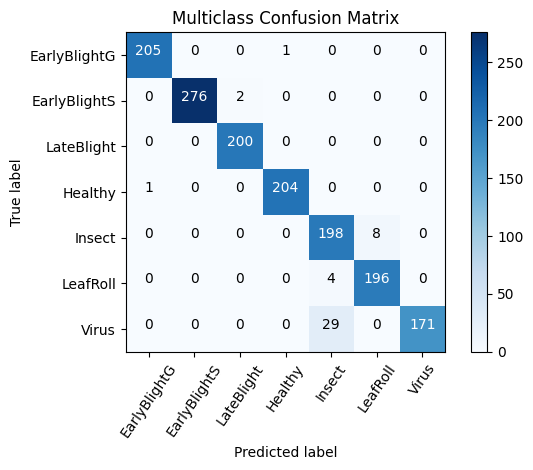

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

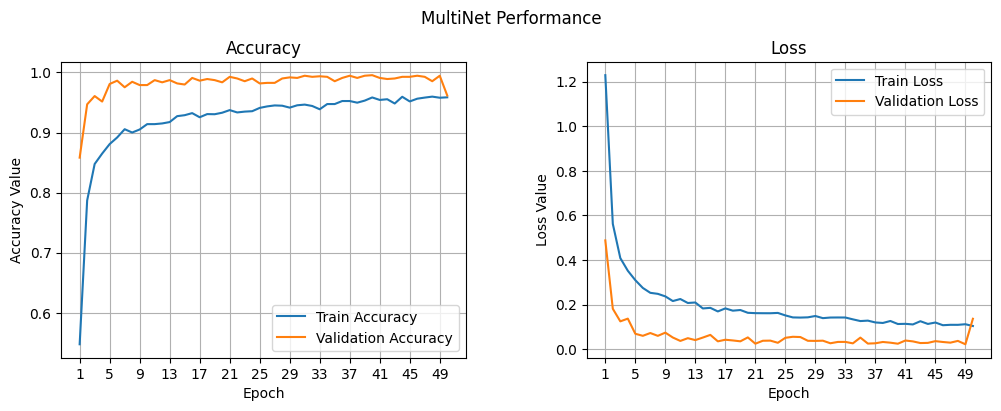

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 5s 119ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      1.00      1.00       206
EarlyBlight Serious       1.00      0.99      1.00       278
         LateBlight       0.99      1.00      1.00       200
            Healthy       1.00      1.00      1.00       205
             Insect       0.86      0.96      0.91       206
           LeafRoll       0.96      0.98      0.97       200
              Virus       1.00      0.85      0.92       200

           accuracy                           0.97      1495
          macro avg       0.97      0.97      0.97      1495
       weighted avg       0.97      0.97      0.97      1495



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(Xception)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 6s 120ms/step
MultiNet(Xception)
Accuracy: 0.9698996655518395
F1 Score: 0.9698326978897694
precision: 0.9720190733797999
recall: 0.9698996655518395
MSE: 0.09899665551839465
MAE: 0.05217391304347826


In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 6s 120ms/step


In [22]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.372972972972973

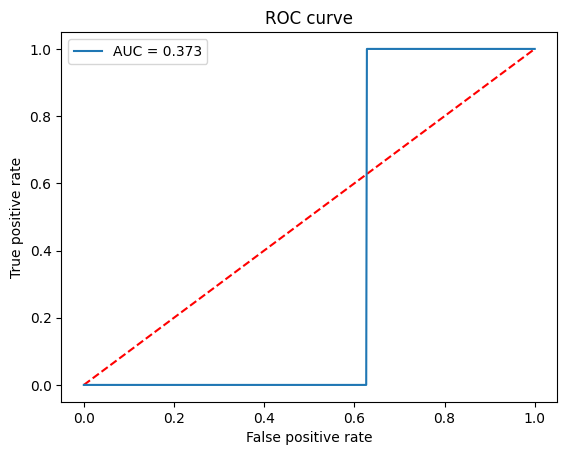

In [23]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
